In [2]:
%matplotlib notebook
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem

paths = [os.path.abspath(path) for path in ["..", "../Source"]]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

In [3]:
def read_results(path):
    with open(os.path.join(path, "metrics.json"), "r") as file:
        return json.load(file)

### MEGNet with conditions

<IPython.core.display.Javascript object>


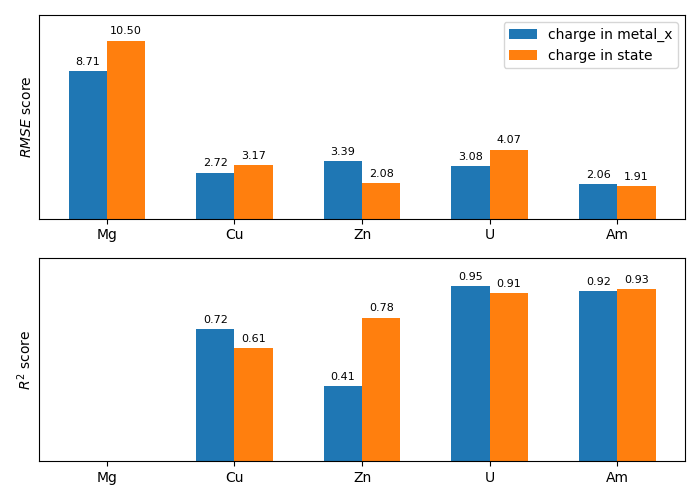

In [4]:
base_path = "../Output/MengetChargeMetal"
folders = [os.path.join(base_path, f) for f in os.listdir(base_path)]
results = [read_results(f) for f in folders]
metals = np.array([f.split("_")[0] for f in os.listdir(base_path)], dtype=object)
ind = np.array([Chem.Atom(metal).GetAtomicNum() for metal in metals]).argsort()
metals = metals[ind]
rmse_metal = np.array([result["logK_test_RMSE"] for result in results])[ind]
r2_metal = np.array([result["logK_test_R2"] for result in results])[ind]

base_path = "../Output/MengetChargeMegnet"
folders = [os.path.join(base_path, f) for f in os.listdir(base_path)]
results = [read_results(f) for f in folders]
rmse_megnet = np.array([result["logK_test_RMSE"] for result in results])[ind]
r2_megnet = np.array([result["logK_test_R2"] for result in results])[ind]

fig, ax = plt.subplots(2, 1, figsize=(7, 5))

width = 0.3
fmt="%.2lf"
float_fontsize=8

bars = []
ind = np.arange(len(rmse_metal))

bars += [ax[0].bar(ind - width/2, rmse_metal, width, label="charge in metal_x")]
ax[0].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)
bars += [ax[0].bar(ind + width/2, rmse_megnet, width, label="charge in state")]
ax[0].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

bars += [ax[1].bar(ind - width/2, r2_metal, width, label="charge in metal_x")]
ax[1].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)
bars += [ax[1].bar(ind + width/2, r2_megnet, width, label="charge in state")]
ax[1].bar_label(bars[-1], padding=3, fmt=fmt, fontsize=float_fontsize)

ax[0].set_ylabel("$RMSE$ score")
ax[0].set_ylim(0, 12)
ax[0].set_yticks([])

ax[1].set_ylabel("$R^2$ score")
ax[1].set_ylim(0, 1.1)
ax[1].set_yticks([])

ax[0].legend()
ax[0].set_xticks(range(len(metals)), metals)
ax[1].set_xticks(range(len(metals)), metals)

fig.tight_layout()
plt.show()